#### Carga de librerías

In [26]:
import keras
from keras.applications.vgg16 import VGG16
from keras.utils import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback  
from livelossplot.inputs.keras import PlotLossesCallback
from sklearn.metrics import accuracy_score
from imutils import paths
import cv2
import random
import os
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from keras.applications.inception_v3 import InceptionV3
from keras.layers import GlobalAveragePooling2D, Dense
from keras.optimizers import Adam
import shutil
from tensorflow.keras.applications import ResNet50
from livelossplot import PlotLossesKerasTF
from tensorflow.keras.applications import DenseNet121

#### Definición de parámetros

Se definen los parámetros importantes para el procesamiento de imágenes, como el ancho y alto de las imágenes (img_width y img_height), y las rutas de las carpetas de entrenamiento y prueba (train_data_dir y test_data_dir).

In [2]:
img_width=224
img_height=224

In [3]:
###### CREAR CARPETAS TRAIN Y TEST #######
# data_dir = 'data'
# classes = ['healthy', 'LLA']
# train_dir = os.path.join(data_dir, 'train')
# test_dir = os.path.join(data_dir, 'test')

# os.makedirs(train_dir, exist_ok=True)
# os.makedirs(test_dir, exist_ok=True)

# for cls in classes:
#     os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
#     os.makedirs(os.path.join(test_dir, cls), exist_ok=True)
#     src_dir = os.path.join(data_dir, cls)
#     all_files = os.listdir(src_dir)
#     train_files, test_files = train_test_split(all_files, test_size=0.2, random_state=42)
    
#     for file in train_files:
#         shutil.move(os.path.join(src_dir, file), os.path.join(train_dir, cls, file))
    
#     for file in test_files:
#         shutil.move(os.path.join(src_dir, file), os.path.join(test_dir, cls, file))


In [4]:
path_base = 'data'
train_data_dir = os.path.join(path_base, 'train')
test_data_dir = os.path.join(path_base, 'test')

#### Generadores de datos

Se crean generadores de datos utilizando ImageDataGenerator de Keras para cargar y preprocesar las imágenes en lotes durante el entrenamiento y la evaluación del modelo. Estos generadores realizan preprocesamiento de datos como normalización, aumento de datos (rotación, zoom, volteo horizontal) y división de datos de entrenamiento en entrenamiento y validación.

In [5]:
train_datagen = ImageDataGenerator(  
    rescale=1. / 255,
    zoom_range=0.2,
    rotation_range = 5,
    horizontal_flip=True,  
    validation_split = 0.2)

test_datagen = ImageDataGenerator(rescale=1. / 255)

In [6]:
batch_size=6

In [7]:
train_generator = train_datagen.flow_from_directory(  
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    subset = 'training',
    shuffle=True,
    class_mode='categorical', 
    seed=42)

validation_generator = train_datagen.flow_from_directory(  
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    subset='validation',
    shuffle=True, 
    class_mode='categorical',
    seed=42)

test_generator= test_datagen.flow_from_directory(
    test_data_dir, 
    target_size=(img_width, img_height), 
    class_mode=None, 
    batch_size=1, 
    shuffle=False, 
    seed=42)

Found 70 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


Found 22 images belonging to 2 classes.


#### Creación del primer modelo base

Se carga la arquitectura InceptionV3 sin la capa densa superior (include_top=False) y se congela para que sus pesos no se actualicen durante el entrenamiento. Esto se hace para aprovechar las características aprendidas en un conjunto de datos de gran escala (ImageNet) y adaptarlas a un conjunto de datos más pequeño y específico.

Se agregan capas adicionales al final de la red para adaptarla a la tarea específica de clasificación de LLA. Esto incluye una capa de agrupamiento global (GlobalAveragePooling2D) para reducir la dimensionalidad de las características y una capa densa (Dense) con función de activación ReLU. Finalmente, se agrega otra capa densa de salida con función de activación softmax para la clasificación multiclase. El número de neuronas en la capa de salida corresponde al número de clases en el conjunto de datos, que en este caso es 2.

Por último, se muestra un resumen del modelo para revisar su arquitectura y el número de parámetros entrenables.

In [8]:
model = InceptionV3(include_top=False, input_shape=(224, 224, 3))
model.trainable = False

In [9]:
x = GlobalAveragePooling2D()(model.output)
x = Dense(1024, activation='relu')(x)
output = Dense(2, activation='softmax')(x)

In [10]:
model = Model(inputs=model.input, outputs=output)
model.summary()

Model: "model"


__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalization[0][0]'] 
          

#### Definición de parámetros y callbacks

In [11]:
epochs= 20
n_steps = train_generator.samples // batch_size
n_val_steps = validation_generator.samples // batch_size

In [12]:
checkpoint = ModelCheckpoint(filepath='best_weights_inceptionv2.h5',
                                  save_best_only=True,
                                  verbose=1)

early_stop = EarlyStopping(monitor='val_loss', patience=8, verbose=1, restore_best_weights=True)  
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4)  
plot_loss_1 = PlotLossesCallback()
callbacks_list = [early_stop, reduce_lr, plot_loss_1,checkpoint]

In [13]:
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

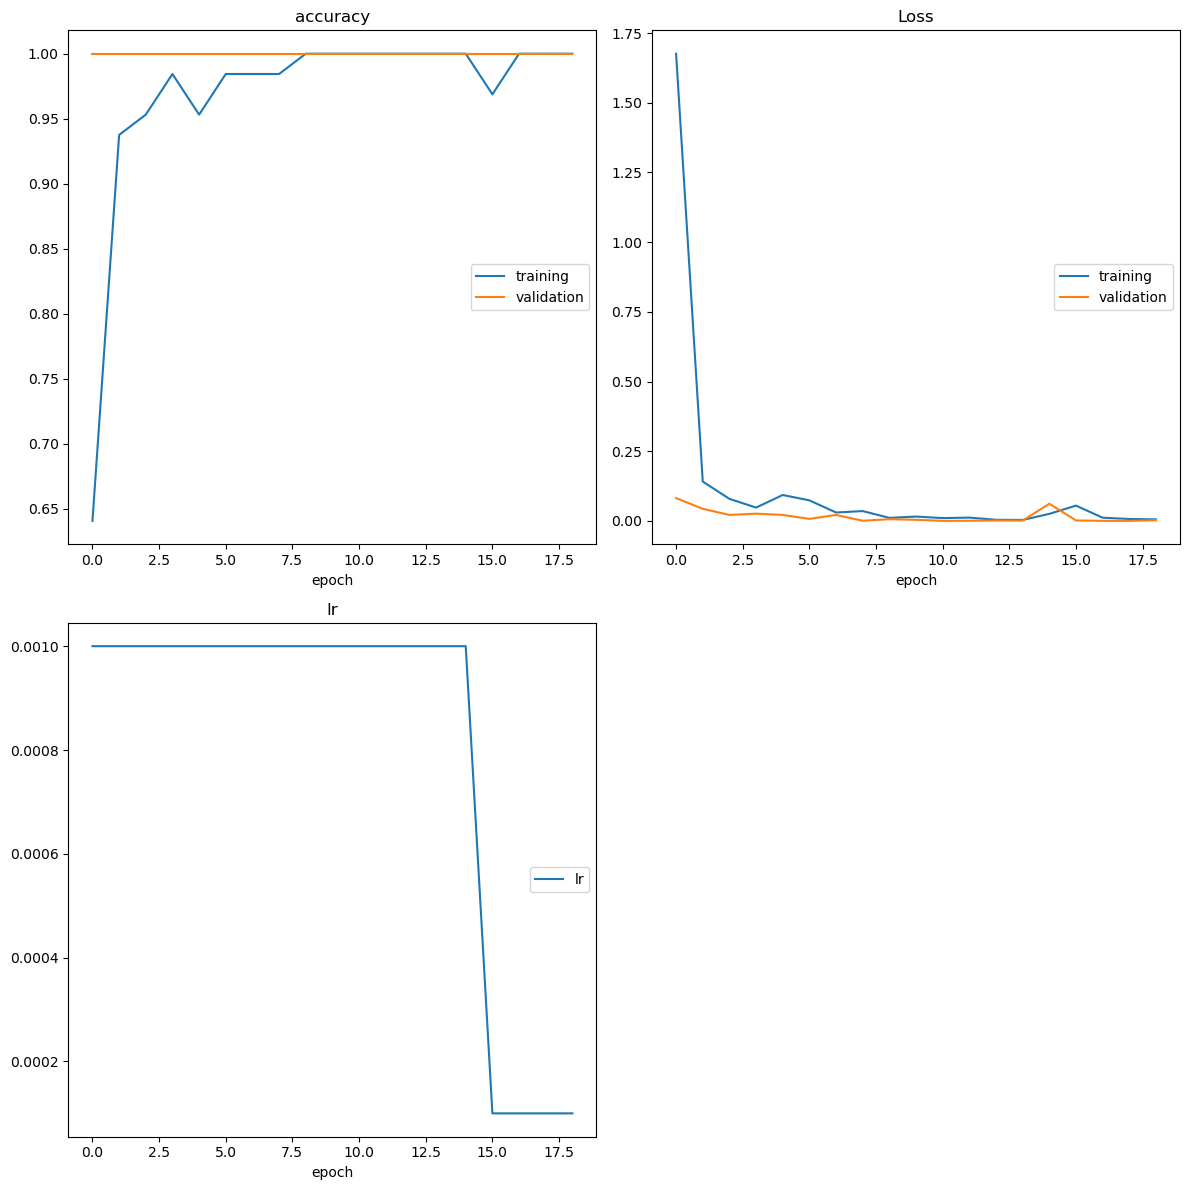

accuracy
	training         	 (min:    0.641, max:    1.000, cur:    1.000)
	validation       	 (min:    1.000, max:    1.000, cur:    1.000)
Loss
	training         	 (min:    0.003, max:    1.676, cur:    0.005)
	validation       	 (min:    0.000, max:    0.082, cur:    0.003)
lr
	lr               	 (min:    0.000, max:    0.001, cur:    0.000)

Epoch 19: val_loss did not improve from 0.00012
11/11 [==============================] - 8s 748ms/step - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.0025 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 19: early stopping


In [14]:
model_history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    steps_per_epoch=n_steps,
    validation_steps=n_val_steps,
    callbacks=callbacks_list
)

In [15]:
true_classes = test_generator.classes
class_indices = test_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

preds = model.predict(test_generator)
pred_classes = np.argmax(preds, axis=1)

22/22 [==============================] - 3s 87ms/step


In [16]:
acc = accuracy_score(true_classes, pred_classes)
print("InceptionV3 Model Accuracy without Fine-Tuning: {:.2f}%".format(acc * 100))

InceptionV3 Model Accuracy without Fine-Tuning: 95.45%


### Conclusiones del modelo InceptionV2

El modelo InceptionV3 alcanzó una precisión del 95.45% sin ajuste fino, lo que indica un rendimiento sólido y una capacidad considerable para clasificar correctamente las imágenes en el conjunto de pruebas.

La gráfica de precisión muestra que tanto la precisión de entrenamiento como la de validación aumentan y se estabilizan en niveles altos, cerca del 100% para la validación. Sin embargo, hay una ligera variabilidad en la precisión de validación al principio, que se estabiliza después de unas pocas épocas. Por otro lado, la gráfica de pérdida muestra una disminución tanto en la pérdida de entrenamiento como en la de validación a lo largo de las épocas, lo cual es un buen indicador de que el modelo está aprendiendo adecuadamente.

A pesar de la alta precisión, la variabilidad inicial en la precisión de validación y las fluctuaciones en la pérdida sugieren que podría haber un riesgo de sobreajuste o inestabilidad temprana en el entrenamiento. Las técnicas de regularización y el uso de callbacks como EarlyStopping y ReduceLROnPlateau ayudan a mitigar estos efectos. El uso de EarlyStopping con restore_best_weights asegura que el modelo no entrene más de lo necesario y que se restaure el mejor conjunto de pesos. Esto previene el sobreajuste y mejora la generalización. En cuanto a el uso de ReduceLROnPlateau, este ajusta la tasa de aprendizaje basada en la pérdida de validación, lo cual ayuda a que el modelo converja más eficientemente. La combinación de estas técnicas ha contribuido a un rendimiento robusto y estable del modelo.



### Creación del segundo modelo base

Se carga la arquitectura `ResNet50` sin la capa densa superior (include_top=False) y se congela para que sus pesos no se actualicen durante el entrenamiento. Esto se hace para aprovechar las características aprendidas en un conjunto de datos de gran escala (ImageNet) y adaptarlas a un conjunto de datos más pequeño y específico.

Se agregan capas adicionales al final de la red para adaptarla a la tarea específica de clasificación de LLA. Esto incluye una capa de agrupamiento global (GlobalAveragePooling2D) para reducir la dimensionalidad de las características y una capa densa (Dense) con función de activación ReLU. Finalmente, se agrega otra capa densa de salida con función de activación softmax para la clasificación multiclase. El número de neuronas en la capa de salida corresponde al número de clases en el conjunto de datos, que en este caso es 2.

Por último, se muestra un resumen del modelo para revisar su arquitectura y el número de parámetros entrenables.

In [17]:
model = ResNet50(include_top=False, input_shape=(img_width, img_height, 3))
model.trainable = False

In [18]:
x = GlobalAveragePooling2D()(model.output)
x = Dense(1024, activation='relu')(x)
output = Dense(2, activation='softmax')(x)

In [19]:
model = Model(inputs=model.input, outputs=output)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [20]:
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
checkpoint = ModelCheckpoint(filepath='best_weights_resnet50.h5', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=8, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4)
plot_loss = PlotLossesKerasTF()

callbacks_list = [early_stop, reduce_lr, plot_loss, checkpoint]

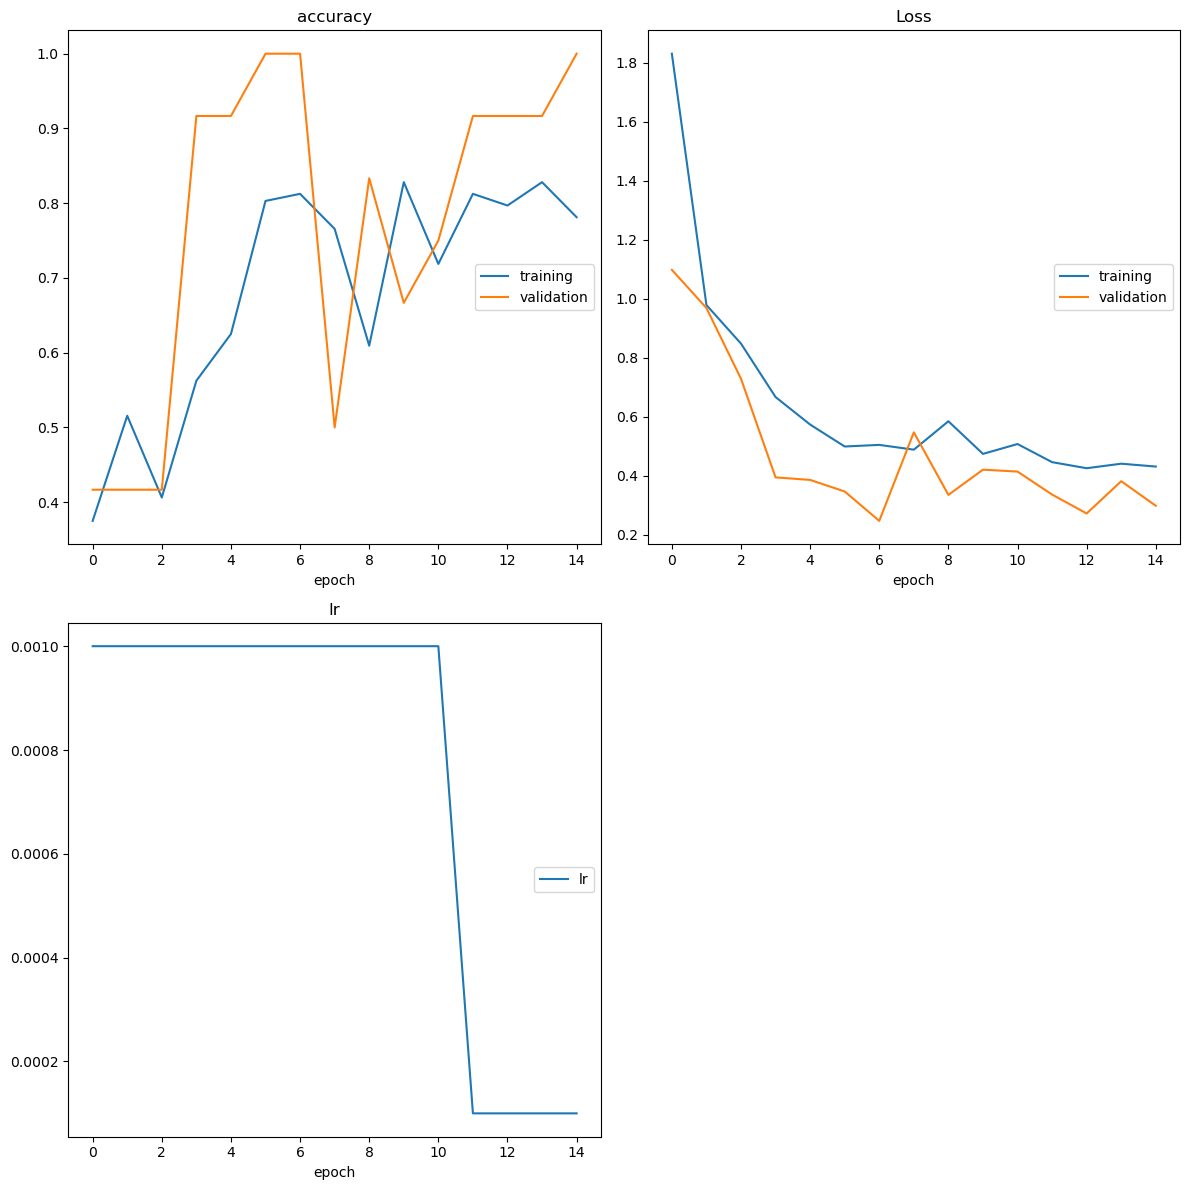

accuracy
	training         	 (min:    0.375, max:    0.828, cur:    0.781)
	validation       	 (min:    0.417, max:    1.000, cur:    1.000)
Loss
	training         	 (min:    0.425, max:    1.831, cur:    0.431)
	validation       	 (min:    0.247, max:    1.098, cur:    0.298)
lr
	lr               	 (min:    0.000, max:    0.001, cur:    0.000)

Epoch 15: val_loss did not improve from 0.24690
11/11 [==============================] - 10s 948ms/step - loss: 0.4310 - accuracy: 0.7812 - val_loss: 0.2980 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 15: early stopping


In [22]:
model_history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    steps_per_epoch=n_steps,
    validation_steps=n_val_steps,
    callbacks=callbacks_list
)

In [23]:
preds = model.predict(test_generator)
pred_classes = np.argmax(preds, axis=1)

acc = accuracy_score(true_classes, pred_classes)
print("ResNet50 Model Accuracy without Fine-Tuning: {:.2f}%".format(acc * 100))

22/22 [==============================] - 4s 128ms/step
ResNet50 Model Accuracy without Fine-Tuning: 86.36%


### Conclusiones del modelo ResNet50

El modelo ResNet50 alcanzó una precisión del 86.36% sin ajuste fino, lo que indica un rendimiento razonable pero con margen para mejoras adicionales en la clasificación de imágenes del conjunto de pruebas.

La precisión del entrenamiento muestra un aumento constante con pequeñas fluctuaciones, indicando que el modelo está aprendiendo progresivamente durante las épocas. En cuanto a la precisión de validación presenta muchas fluctuaciones, lo que sugiere inestabilidad y posibles variaciones en la capacidad del modelo para generalizar a datos no vistos.

Por otro lado, la pérdida de entrenamiento disminuye de manera constante con pequeñas fluctuaciones, señalando que el modelo está mejorando su capacidad de ajuste a los datos de entrenamiento. De la misma manera, la pérdida de validación también disminuye, pero con pequeñas fluctuaciones, lo que indica que el modelo está aprendiendo pero puede estar experimentando variabilidad en su rendimiento de validación.

De igual forma que en el anterior modelo, las técnicas de regularización y el uso de callbacks como EarlyStopping y ReduceLROnPlateau ayudan a mitigar el riesgo de sobreajuste o inestabilidad temprana en el entrenamiento debido a la variabilidad y las fluctuaciones que se observan en la precisión y perdida. 